# Preprocessing time series with aeon

It is common to need to preprocess time series data before applying machine learning
algorithms. So algorithms can handle these characteristics, or `aeon` transformers can be used to preprocess collections of time
series into standard format. This notebook demonstrates three common use cases

1. [Rescaling time series](#Rescaling-time-series)
2. [Resizing time series](#Resizing-time-series)
3. [Dealing with missing values](#missing-values)


## Rescaling time series

Different levels of scale and variance can mask discriminative patterns in time
series. This is particularly true for methods that are based on distances. It common
to rescale time series to have zero mean and unit variance. For example, the data in
the `UnitTest` dataset is a subset of the [Chinatown dataset]
(https://timeseriesclassification.com/description.php?Dataset=Chinatown. These are
counts of pedestrians in Chinatown, Melbourne. The time series are of different means

In [3]:
import numpy as np

from aeon.datasets import load_unit_test

X, y = load_unit_test(split="Train")
np.mean(X, axis=-1)[0:5]

array([[561.875     ],
       [604.95833333],
       [629.16666667],
       [801.45833333],
       [540.75      ]])

In [4]:
np.std(X, axis=-1)[0:5]

array([[428.95224215],
       [483.35481095],
       [514.90052977],
       [629.00847763],
       [389.10059218]])

We can rescale the time series in three ways:
1. Normalise: subtract the mean and divide by the standard deviation to make all
series have zero mean and unit variance.

In [5]:
from aeon.transformations.collection import Normalizer

normalizer = Normalizer()
X2 = normalizer.fit_transform(X)
np.round(np.mean(X2, axis=-1)[0:5], 6)

array([[ 0.],
       [-0.],
       [ 0.],
       [-0.],
       [-0.]])

In [6]:
np.round(np.std(X2, axis=-1)[0:5], 6)

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]])

2. Re-center: Recentering involves subtracting the mean of each series

In [7]:
from aeon.transformations.collection import Centerer

c = Centerer()
X3 = c.fit_transform(X)
np.round(np.mean(X3, axis=-1)[0:5], 6)

array([[ 0.],
       [-0.],
       [ 0.],
       [-0.],
       [ 0.]])

3. Min-Max: Scale the data to be between 0 and 1

In [8]:
from aeon.transformations.collection import MinMaxScaler

minmax = MinMaxScaler()
X4 = minmax.fit_transform(X)
np.round(np.min(X4, axis=-1)[0:5], 6)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [9]:
np.round(np.max(X4, axis=-1)[0:5], 6)

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]])

There is no best way to do this, although for counts such as this it is more common
to MinMax scale, so that the data still has some interpretation as proportions.

## Resizing time series

Suppose we have a collections of time series with different lengths, i.e. different
number of time points. Currently, most of aeon's collection estimators
(classification, clustering or regression) require equal-length time
series. Those that can handle unequal length series are tagged with
"capability:unequal".

In [10]:
from aeon.classification.convolution_based import RocketClassifier
from aeon.datasets import load_basic_motions, load_japanese_vowels, load_plaid
from aeon.utils.validation import has_missing, is_equal_length, is_univariate

If you want to use an estimator that cannot internally handle missing values, one
option is to convert unequal length series into equal length. This can be
 done through padding, truncation or resizing through fitting a function and
 resampling.

### Unequal or equal length collections time series

If a collection contains all equal length series, it will store the data in a 3D
numpy of shape `(n_cases, n_channels, n_timepoints)`. If it is unequal length, it is
stored in a list of 2D numpy arrays:

In [11]:
# Equal length multivariate data
bm_X, bm_y = load_basic_motions()
X = bm_X
print(f"{type(X)}, {X.shape}")
print(
    f"univariate = {is_univariate(X)}, has missing ={has_missing(X)}, equal "
    f"length = {is_equal_length(X)}"
)

<class 'numpy.ndarray'>, (80, 6, 100)
univariate = False, has missing =False, equal length = True


In [12]:
# Unequal length univariate data
plaid_X, plaid_y = load_plaid()
X = plaid_X
print(type(plaid_X), "\n", plaid_X[0].shape, "\n", plaid_X[10].shape)
print(
    f"univariate = {is_univariate(X)}, has missing ={has_missing(X)}, equal "
    f"length = {is_equal_length(X)}"
)

<class 'list'> 
 (1, 500) 
 (1, 300)
univariate = True, has missing =False, equal length = False


In [13]:
vowels_X, vowels_y = load_japanese_vowels(split="train")
X = vowels_X
print(
    f"univariate = {is_univariate(X)}, has missing ={has_missing(X)}, equal "
    f"length = {is_equal_length(X)}"
)

univariate = False, has missing =False, equal length = False


In [14]:
series_lengths = [array.shape[1] for array in plaid_X]

# Find the minimum and maximum of the second dimensions
min_length = min(series_lengths)
max_length = max(series_lengths)
print(" Min length = ", min_length, " max length = ", max_length)

 Min length =  100  max length =  1344


There are two basic strategies for unequal length problems
1. Use an estimator that can internally handle missing values
2. Transform the data to be equal length by, for example, truncating or padding series

Estimators with the tag `"capability:unequal_length": True` have the capability to
handle unequal length series. For classification, regression and
clusterign, the
current list is

In [15]:
from aeon.utils.discovery import all_estimators

all_estimators(
    type_filter=["classifier", "regressor", "clusterer"],
    tag_filter={"capability:unequal_length": True},
)

[('Catch22Classifier',
  aeon.classification.feature_based._catch22.Catch22Classifier),
 ('Catch22Clusterer', aeon.clustering.feature_based._catch22.Catch22Clusterer),
 ('Catch22Regressor', aeon.regression.feature_based._catch22.Catch22Regressor),
 ('DummyClassifier', aeon.classification.dummy.DummyClassifier),
 ('DummyRegressor', aeon.regression._dummy.DummyRegressor),
 ('ElasticEnsemble',
  aeon.classification.distance_based._elastic_ensemble.ElasticEnsemble),
 ('KNeighborsTimeSeriesClassifier',
  aeon.classification.distance_based._time_series_neighbors.KNeighborsTimeSeriesClassifier),
 ('KNeighborsTimeSeriesRegressor',
  aeon.regression.distance_based._time_series_neighbors.KNeighborsTimeSeriesRegressor),
 ('RDSTClassifier', aeon.classification.shapelet_based._rdst.RDSTClassifier),
 ('RDSTRegressor', aeon.regression.shapelet_based._rdst.RDSTRegressor)]

You can pass these estimators unequal length series and they will work as expected.


In [16]:
from aeon.classification.distance_based import KNeighborsTimeSeriesClassifier

knn = KNeighborsTimeSeriesClassifier()
model = knn.fit(plaid_X, plaid_y)

If time series are unequal length, collection estimators will raise an error if they
do not have the capability to handle this characteristic. If you want to use them, 
you will need to preprocess the data to be equal length. 

In [17]:
rc = RocketClassifier()
try:
    rc.fit(plaid_X, plaid_y)
except ValueError as e:
    print(f"ValueError: {e}")

ValueError: Data seen by instance of RocketClassifier has unequal length series, but RocketClassifier cannot handle unequal length series. 


### Padding, truncating or resizing.

We can pad, truncate or resize. By default, pad adds zeros to make all series the
length of the longest, truncate removes all values beyond the length of the shortest
and resize stretches or shrinks the series.

In [18]:
from aeon.transformations.collection import Padder, Resizer, Truncator

pad = Padder()
truncate = Truncator()
resize = Resizer(length=600)
X2 = pad.fit_transform(plaid_X)
X3 = truncate.fit_transform(plaid_X)
X4 = resize.fit_transform(plaid_X)
print(X2.shape, "\n", X3.shape, "\n", X4.shape)

(1074, 1, 1344) 
 (1074, 1, 100) 
 (1074, 1, 600)


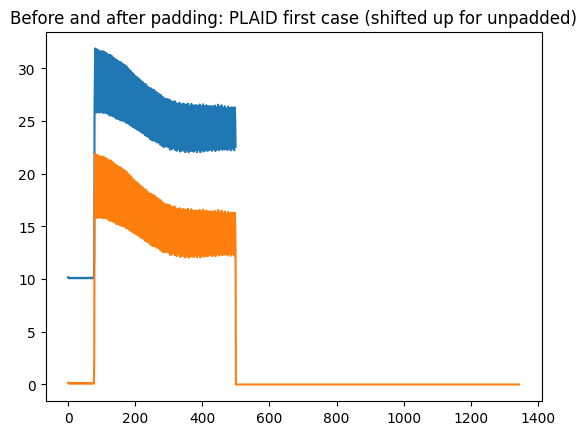

In [19]:
import matplotlib.pyplot as plt

plt.title("Before and after padding: PLAID first case (shifted up for unpadded)")
plt.plot(plaid_X[0][0] + 10)
plt.plot(X2[0][0])

You can put these transformers in a pipeline to apply to both train/test split


In [20]:
from sklearn.metrics import accuracy_score

# Unequal length univariate data
from aeon.pipeline import make_pipeline

train_X, train_y = load_plaid(split="Train")
test_X, test_y = load_plaid(split="Test")
steps = [truncate, rc]
pipe = make_pipeline(steps)
pipe.fit(train_X, train_y)
preds = pipe.predict(test_X)
accuracy_score(train_y, preds)

0.813780260707635

## Missing Values

Missing values are indicated by `NaN` in numpy array. You can test whether any `aeon`
 data structure contains missing values using the utility function

In [21]:
X = np.random.random(size=(10, 2, 200))
has_missing(X)

False

In [22]:
X[5][0][55] = np.NAN
has_missing(X)

True

There are a range of strategies for handling missing values. These include:

1. Use an estimator that internally handles missing values. It is fairly easy for
some algorithms (such as decision trees) to internally deal with missing values,
usually be using it as a distinct series value after discretisation. We do not yet 
have many estimators with this capability. Estimators that are able to internally 
handle missing values are tagged with `"capability:missing_values": True`.

In [23]:
from aeon.utils.discovery import all_estimators

all_estimators(
    tag_filter={"capability:missing_values": True},
)

[('BORF', aeon.transformations.collection.dictionary_based._borf.BORF),
 ('CollectionId',
  aeon.transformations.collection.compose._identity.CollectionId),
 ('DummyClassifier', aeon.classification.dummy.DummyClassifier),
 ('DummyRegressor', aeon.regression._dummy.DummyRegressor),
 ('RandomSegmenter', aeon.segmentation._random.RandomSegmenter),
 ('STRAY', aeon.anomaly_detection._stray.STRAY),
 ('SimpleImputer', aeon.transformations.collection._impute.SimpleImputer)]

2. Removing series with missing: this is often desirable if the train set size is
large, the number of series with missing is small and the proportion of missing
values for these series is high.

We do not yet have a transformer for this, but it is easy to implement yourself.

3. Interpolating missing values from series: estimating the missing values from the 
other values in a time series is commonly done. This is
 often desirable if the train set size is small and the proportion of missing values
 is low. You can do this with the transformer ``SimpleImputer``. This interpolates 
 each series and each channel independently. So for example a mean interpolation 
 of series with two channels `[[NaN,1.0,2.0,3.0],[-1.0,-2.0,-3.0,-4.0]]` would be 
 `[[2.0,1.0,2.0,3.0],[-1.0,-2.0,-3.0,-4.0]]`. 

In [26]:
from aeon.transformations.collection import SimpleImputer

imput = SimpleImputer(strategy="mean")
X2 = imput.fit_transform(X)
has_missing(X2)

False

In [27]:
imp2 = SimpleImputer(strategy="median")
X3 = imp2.fit_transform(X)
has_missing(X3)

False

In [28]:
imp3 = SimpleImputer(strategy="constant", fill_value=0)
X4 = imp3.fit_transform(X)
has_missing(X4)

False